## Libraries

In [200]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [201]:
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


## Constants

In [202]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 10
TRAINING_DIR = Path('./uc-data/Training Dataset (1002 images)')
TEST_DIR = Path('./uc-data/Test Dataset')

## Functions

In [203]:
def plot_hist(hist, metric="acc"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Load dataset + Data Augmentation

### Training & Validation dataset

In [204]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale the images by 1/255
    rotation_range=30,  # Rotate the images by up to 30 degrees
    width_shift_range=0.05,  # Shift the images horizontally by up to 5%
    height_shift_range=0.05,  # Shift the images vertically by up to 5%
    zoom_range=0.10,  # Zoom in on the images by up to 10%
    horizontal_flip=True,  # Flip the images horizontally
    fill_mode="nearest",  # Fill in the empty pixels with the nearest pixel
    validation_split=0.2,  # Use 20% of the images for validation
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale the images by 1/255
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Resize the images to (224, 224)
    batch_size=BATCH_SIZE,  # Use a batch size of 32
    class_mode="categorical",  # Use categorical labels
    subset="training",  # Use the training subset
    shuffle=True, seed=13
)

validation_generator = valid_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Resize the images to (224, 224)
    batch_size=BATCH_SIZE,  # Use a batch size of 32
    class_mode="categorical",  # Use categorical labels
    subset="validation",  # Use the validation subset}
    shuffle=True, seed=13
)

Found 804 images belonging to 6 classes.
Found 198 images belonging to 6 classes.


In [205]:
class_indices = {v: k for k, v in train_generator.class_indices.items()}
class_indices

{0: 'CHIPS_BROKEN_COATED',
 1: 'CHIP_BROKEN_UNCOATED',
 2: 'COATING_DEFECTS',
 3: 'EDGE_DEFECTS',
 4: 'Good',
 5: 'LOGO_DEFECTS'}

In [206]:
num_classes = len(class_indices)
num_classes

6

### Test dataset

In [207]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Found 2744 images belonging to 6 classes.


In [208]:
print(f"Training Samples: {train_generator.samples}")
print(f"Validation Samples: {validation_generator.samples}")
print(f"Test Samples: {test_generator.samples}")

Training Samples: 804
Validation Samples: 198
Test Samples: 2744


### Print samples of the Data Augmentation process

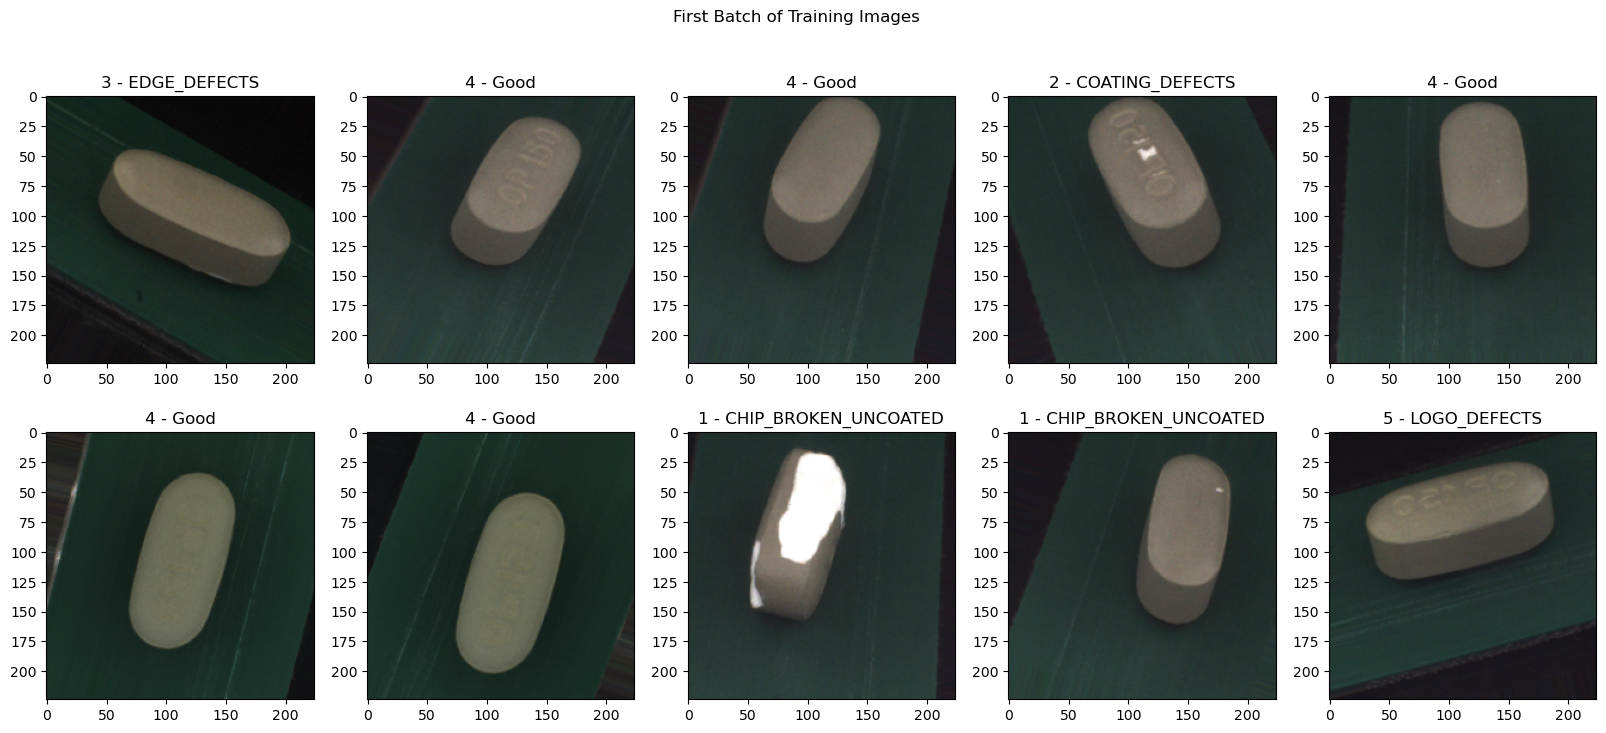

In [209]:
first_batch = train_generator.next()
first_batch_images = first_batch[0]
first_batch_labels = first_batch[1]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1: 
        image_data = first_batch_images[ind]
        ax2.imshow(image_data)
        label_index = first_batch_labels[ind].argmax()
        ax2.set_title(f"{label_index} - {class_indices[label_index]}")
        ind += 1

fig.suptitle('First Batch of Training Images') 
plt.show()

In [210]:
# Count the number of samples in each class
class_counts = np.unique(train_generator.classes, return_counts=True)[1]

# Print the percentage of samples that belong to each class
print("Training set class distribution:")
for i, count in enumerate(class_counts):
    print(f'Class {i}: {count/len(train_generator.classes):.2%} ({count})')
print(f"Total samples: {train_generator.samples}")

Training set class distribution:
Class 0: 10.20% (82)
Class 1: 9.45% (76)
Class 2: 10.20% (82)
Class 3: 10.20% (82)
Class 4: 49.75% (400)
Class 5: 10.20% (82)
Total samples: 804


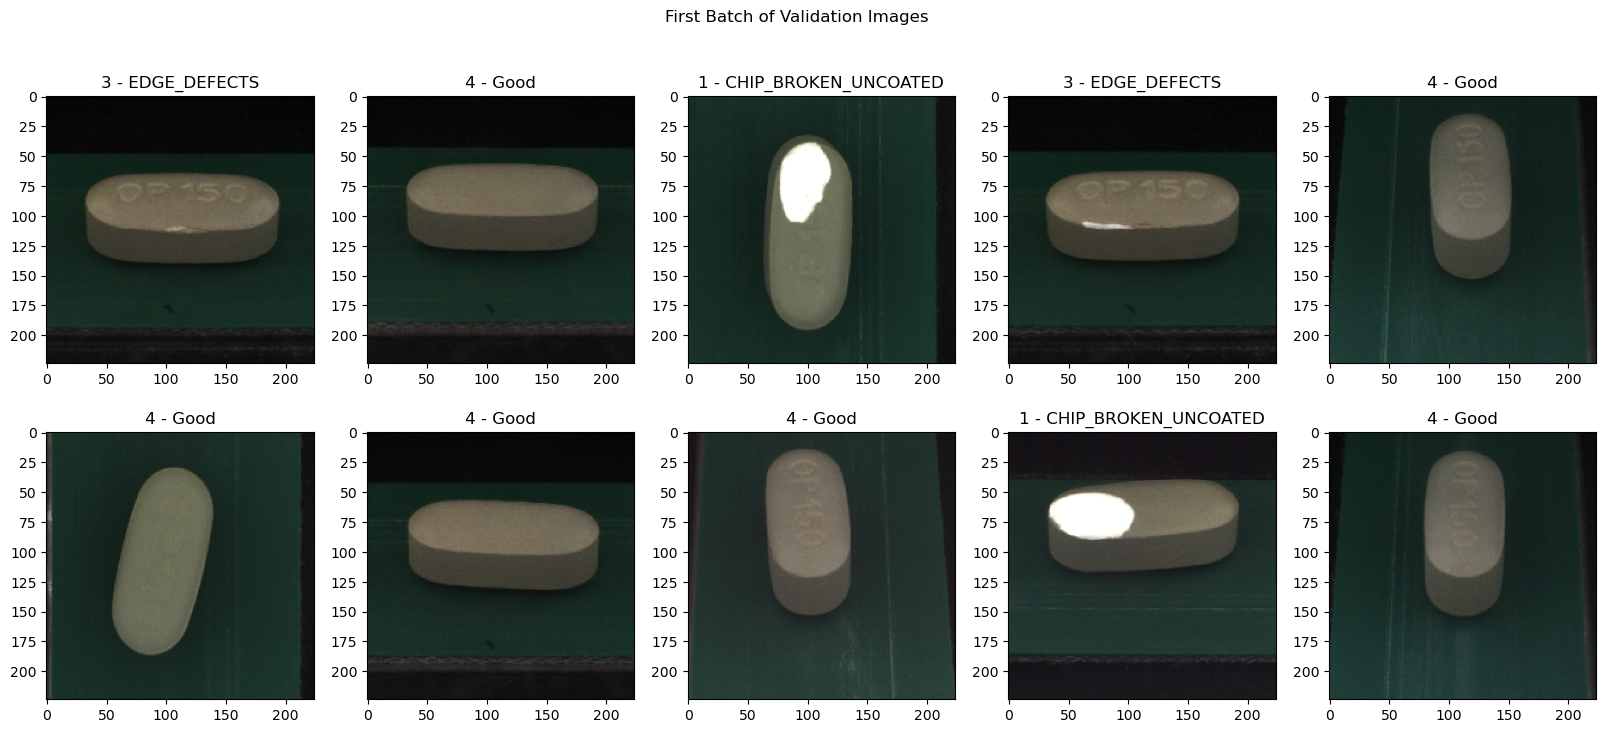

In [211]:
first_batch = validation_generator.next()
first_batch_images = first_batch[0]
first_batch_labels = first_batch[1]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1: 
        image_data = first_batch_images[ind]
        ax2.imshow(image_data)
        label_index = first_batch_labels[ind].argmax()
        ax2.set_title(f"{label_index} - {class_indices[label_index]}")
        ind += 1

fig.suptitle('First Batch of Validation Images') 
plt.show()

In [212]:
# Count the number of samples in each class
class_counts = np.unique(validation_generator.classes, return_counts=True)[1]

# Print the percentage of samples that belong to each class
print("Validation set class distribution:")
for i, count in enumerate(class_counts):
    print(f'Class {i}: {count/len(validation_generator.classes):.2%} ({count})')
print(f"Total samples: {validation_generator.samples}")

Validation set class distribution:
Class 0: 10.10% (20)
Class 1: 9.09% (18)
Class 2: 10.10% (20)
Class 3: 10.10% (20)
Class 4: 50.51% (100)
Class 5: 10.10% (20)
Total samples: 198


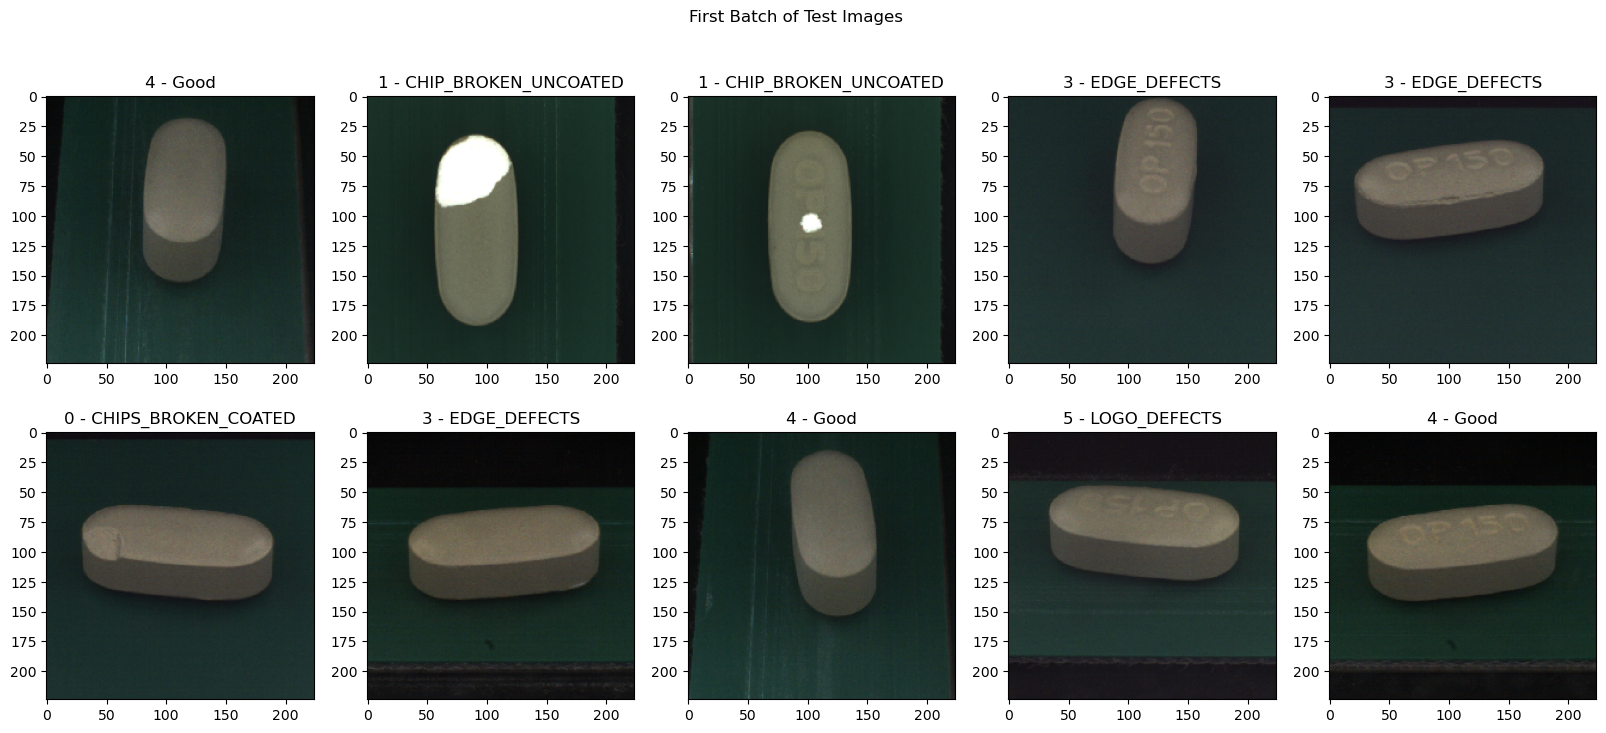

In [213]:
first_batch = test_generator.next()
first_batch_images = first_batch[0]
first_batch_labels = first_batch[1]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1: 
        image_data = first_batch_images[ind]
        ax2.imshow(image_data)
        label_index = first_batch_labels[ind].argmax()
        ax2.set_title(f"{label_index} - {class_indices[label_index]}")
        ind += 1

fig.suptitle('First Batch of Test Images') 
plt.show()

In [214]:
# Count the number of samples in each class
class_counts = np.unique(test_generator.classes, return_counts=True)[1]

# Print the percentage of samples that belong to each class
print("Test set class distribution:")
for i, count in enumerate(class_counts):
    print(f'Class {i}: {count/len(test_generator.classes):.2%} ({count})')
print(f"Total samples: {test_generator.samples}")

Test set class distribution:
Class 0: 10.02% (275)
Class 1: 7.62% (209)
Class 2: 11.30% (310)
Class 3: 12.28% (337)
Class 4: 51.13% (1403)
Class 5: 7.65% (210)
Total samples: 2744


## Model creation
We will use EfficientNetB0

In [215]:
# # conv_base = tf.keras.applications.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# # conv_base = tf.keras.applications.EfficientNetV2B2(weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# # conv_base = tf.keras.applications.ResNet50(include_top=False, classes=num_classes, weights=None, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# conv_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# model = tf.keras.models.Sequential() # Create a sequential model
# model.add(conv_base) # Add the convolutional base to the model
# model.add(tf.keras.layers.GlobalMaxPooling2D(name="gap")) # Add a global spatial average pooling layer
# model.add(tf.keras.layers.Dropout(rate=0.2, name="dropout_out")) # Add a dropout layer with a dropout rate of 0.2 to avoid overfitting
# model.add(tf.keras.layers.Dense(num_classes, activation="softmax", name="fc_out")) # Set NUMBER_OF_CLASSES to the number of your final predictions.
# # conv_base.trainable = False

In [216]:
# conv_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), pooling='avg')
# model = tf.keras.models.Sequential()
# model.add(conv_base)
# model.add(tf.keras.layers.Dropout(rate=0.2, name="dropout_out"))
# model.add(tf.keras.layers.Dense(num_classes, activation="softmax", name="fc_out"))

In [217]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [218]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
# model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(1024, activation='relu'))
# # model.add(tf.keras.layers.Dense(512, activation='relu'))
# # model.add(tf.keras.layers.Dense(256, activation='relu'))
# # model.add(tf.keras.layers.Dense(512, activation='relu'))
# # model.add(tf.keras.layers.Dense(1024, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))# 

In [219]:
# inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# x = tf.keras.applications.EfficientNetB0(weights=None, include_top=False, classes=num_classes)(inputs)
# x = tf.keras.layers.GlobalMaxPooling2D(name="gap")(x)
# outputs = tf.keras.layers.Dropout(rate=0.2, name="dropout_out")(x)
# outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="fc_out")(outputs)

# model = tf.keras.Model(inputs, outputs)
# model.compile(
#     optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
# )

In [220]:
# model_d=tf.keras.applications.DenseNet121(weights=None,include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 

# x=model_d.output

# x= tf.keras.layers.GlobalAveragePooling2D()(x)
# x= tf.keras.layers.BatchNormalization()(x)
# x= tf.keras.layers.Dropout(0.5)(x)
# x= tf.keras.layers.Dense(1024,activation='relu')(x) 
# x= tf.keras.layers.Dense(512,activation='relu')(x) 
# x= tf.keras.layers.BatchNormalization()(x)
# x= tf.keras.layers.Dropout(0.5)(x)

# preds=tf.keras.layers.Dense(num_classes,activation='softmax')(x) #FC-layer
# model = tf.keras.Model(inputs=model_d.input,outputs=preds)


In [221]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [222]:
# input_tensor = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
# x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(2048, activation='elu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(1024, activation='elu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(512, activation='elu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name="Output_Layer")(x)
# model = tf.keras.Model(input_tensor, output_layer)

In [223]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 26, 26, 128)     

In [224]:
model.compile(
    loss="categorical_crossentropy",
    # optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

In [225]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [226]:
# class_weights = generate_class_weights(train_generator.classes, multi_class=True, one_hot_encoded=False)
# class_weights

In [227]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_generator.classes), y=train_generator.classes)
# Convert to dictionary
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.6341463414634145,
 1: 1.763157894736842,
 2: 1.6341463414634145,
 3: 1.6341463414634145,
 4: 0.335,
 5: 1.6341463414634145}

In [228]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto', verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE, 
    epochs=500,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping_cb, reduce_lr_cb],
    class_weight=class_weights,
    # use_multiprocessing=True,
    # workers=4,
)

Epoch 1/500
25/25 [==============================] - 10s 363ms/step - loss: 1.7905 - accuracy: 0.3756 - val_loss: 1.7713 - val_accuracy: 0.1771
Epoch 2/500
25/25 [==============================] - 8s 317ms/step - loss: 1.7929 - accuracy: 0.1399 - val_loss: 1.7802 - val_accuracy: 0.1823
Epoch 3/500
25/25 [==============================] - 8s 323ms/step - loss: 1.7844 - accuracy: 0.1125 - val_loss: 1.7794 - val_accuracy: 0.0938
Epoch 4/500
25/25 [==============================] - 8s 320ms/step - loss: 1.7924 - accuracy: 0.1723 - val_loss: 1.7547 - val_accuracy: 0.1979
Epoch 5/500
25/25 [==============================] - 8s 316ms/step - loss: 1.7785 - accuracy: 0.1218 - val_loss: 1.7275 - val_accuracy: 0.4062
Epoch 6/500
25/25 [==============================] - 8s 300ms/step - loss: 1.7635 - accuracy: 0.2448 - val_loss: 1.7617 - val_accuracy: 0.2344
Epoch 7/500
25/25 [==============================] - 8s 315ms/step - loss: 1.7677 - accuracy: 0.2241 - val_loss: 1.7045 - val_accuracy: 0.416

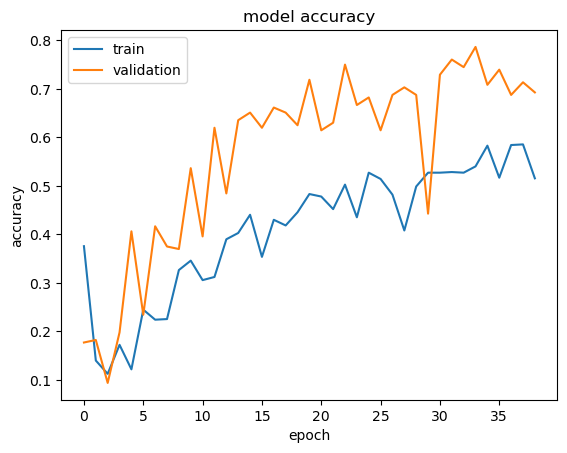

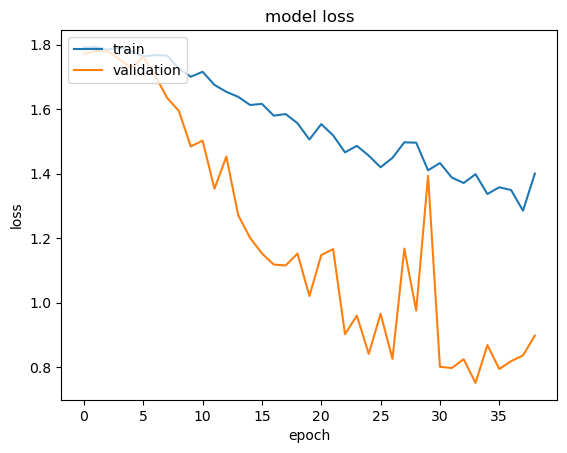

In [229]:
plot_hist(history, "accuracy")
plot_hist(history, "loss")

In [230]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"test_loss: {test_loss}, test_acc: {test_acc}")

86/86 [==============================] - 6s 65ms/step - loss: 0.9690 - accuracy: 0.6676
test_loss: 0.9690233469009399, test_acc: 0.6676384806632996


In [231]:
y_pred = model.predict(test_generator)
y_pred = y_pred.argmax(axis=1)
y_true = test_generator.classes

86/86 [==============================] - 6s 63ms/step


In [232]:
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.01      0.02       275
           1       0.07      0.07      0.07       209
           2       0.12      0.10      0.11       310
           3       0.12      0.07      0.09       337
           4       0.51      0.55      0.53      1403
           5       0.08      0.20      0.11       210

    accuracy                           0.32      2744
   macro avg       0.16      0.17      0.16      2744
weighted avg       0.31      0.32      0.31      2744

[[  4  23  34  17 143  54]
 [  4  14  27  18 107  39]
 [  4  28  30  26 175  47]
 [ 10  17  27  25 191  67]
 [ 25 103 120 116 765 274]
 [  3  21  21  11 112  42]]


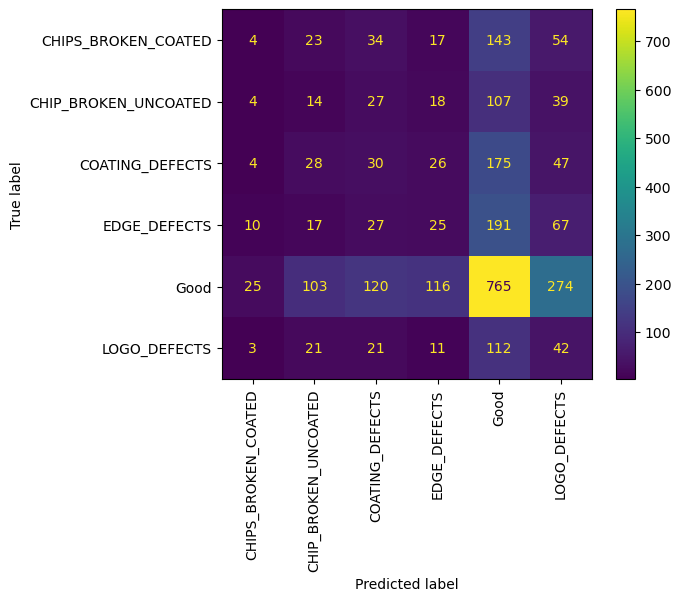

In [233]:
cmd = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_indices.values())
cmd.plot(xticks_rotation="vertical")
plt.show()